This notebook uses SVM to do image classification.

# 1. Load data

In [1]:
import numpy as np
import torchvision
import matplotlib.pyplot as plt

In [2]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# functions to show an image
def imshow(img):
    npimg = np.array(img)
    plt.imshow(npimg)

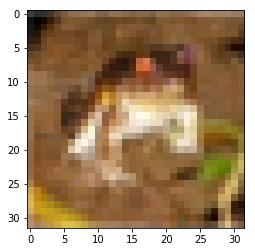

In [5]:
imshow(trainset[0][0])

# 2. Preprocess images: grayscale conversion + feature extraction

In [6]:
import cv2
from cyvlfeat.sift.dsift import dsift

In [7]:
# preprocess images from training set
trftr = np.zeros((len(trainset), 128))
trlb = np.zeros((len(trainset),1), dtype=np.int)
for i in range(len(trainset)):
    npimg = np.array(trainset[i][0])
    gray = cv2.cvtColor(npimg,cv2.COLOR_BGR2GRAY)
    _, dec = dsift(gray, size=8, step=8)
    trftr[i] = dec
    trlb[i, 0] = trainset[i][1]

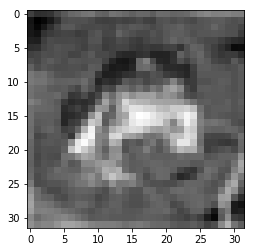

In [8]:
# print a grayscale image
npimg = np.array(trainset[0][0])
gray = cv2.cvtColor(npimg,cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

In [9]:
np.save('./SVM/trftr.npy', trftr)
np.save('./SVM/trlb.npy', trlb)

In [10]:
# preprocess images from testing set
tsftr = np.zeros((len(testset), 128))
tslb = np.zeros((len(testset),1), dtype=np.int)
for i in range(len(testset)):
    npimg = np.array(testset[i][0])
    gray= cv2.cvtColor(npimg,cv2.COLOR_BGR2GRAY)
    _, dec = dsift(gray, size=8, step=8)
    tsftr[i] = dec
    tslb[i, 0] = testset[i][1]

In [11]:
np.save('./SVM/tsftr.npy', tsftr)
np.save('./SVM/tslb.npy', tslb)

# 3. Preprocess images: normalization + PCA
# 4. Classify images with SVM 

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC  
import pickle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [12]:
accuracyList = []
class_accuracyList = []
NUMPCA = [2, 4, 8, 16, 32, 64, 128]
KERNELType = ['linear', 'poly','rbf','sigmoid']

for i in range(len(NUMPCA)):
    for j in range(len(KERNELType)):
        numPCA = NUMPCA[i]
        kernelType = KERNELType[j]

        # load training and test dataset
        trftr = np.load('./SVM/trftr.npy')
        trlb = np.load('./SVM/trlb.npy')
        tsftr = np.load('./SVM/tsftr.npy')
        tslb = np.load('./SVM/tslb.npy')

        # standardizing the features (mean = 0 and variance = 1)
        strftr = StandardScaler().fit_transform(trftr)
        stsftr = StandardScaler().fit_transform(tsftr)

        # identify principal components
        pca = PCA(n_components = numPCA)
        trPCs = pca.fit_transform(strftr)
        tsPCs = pca.fit_transform(stsftr)

        # use SVM to do image classification
        svclassifier = SVC(kernel = kernelType)  
        svclassifier.fit(trPCs, trlb[:,0]) 

#     !!! The saving-classifiers part is commented to avoid override of the existing classifiers  
#         # save the SVM classifier
#         filename = './SVM/'+str(numPCA)+'_'+kernelType+'_'+'SVM.sav'
#         pickle.dump(svclassifier, open(filename, 'wb'))

        # make predictions
        lb_pred = svclassifier.predict(tsPCs)
        
        # generate confusion matrix
        cm = confusion_matrix(tslb, lb_pred)
        
        # calculate accuracy
        accuracy = accuracy_score(tslb, lb_pred)
        accuracyList.append(accuracy)
        class_accuracy = 100 * cm.diagonal() / 1000
        class_accuracyList.append(class_accuracy)

# !!! The writing-to-file part is commented to avoid override of the existing output 
# # write output
# np.savetxt("./SVM/accuracyList.csv",accuracyList, delimiter=",", fmt='%s')
# np.savetxt("./SVM/class_accuracyList.csv",class_accuracyList, delimiter=",", fmt='%s')

/Users/jianyuandeng/miniconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/jianyuandeng/miniconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/jianyuandeng/miniconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/jianyuandeng/miniconda3/

# 5. Pick a SVM classifier and plot the confusion matrix

In [13]:
import seaborn as sn

In [14]:
NUMPCA = [4]
KERNELType = ['rbf']

for i in range(len(NUMPCA)):
    for j in range(len(KERNELType)):
        numPCA = NUMPCA[i]
        kernelType = KERNELType[j]
        
        # load classifier
        filename = './SVM/'+str(numPCA)+'_'+kernelType+'_'+'SVM.sav'
        svclassifier = pickle.load(open(filename, 'rb'))

        # load training and test dataset
        trftr = np.load('./SVM/trftr.npy')
        trlb = np.load('./SVM/trlb.npy')
        tsftr = np.load('./SVM/tsftr.npy')
        tslb = np.load('./SVM/tslb.npy')

        # standardizing the features (mean = 0 and variance = 1)
        strftr = StandardScaler().fit_transform(trftr)
        stsftr = StandardScaler().fit_transform(tsftr)

        # identify principal components
        pca = PCA(n_components = numPCA)
        trPCs = pca.fit_transform(strftr)
        tsPCs = pca.fit_transform(stsftr)

        # make predictions
        lb_pred = svclassifier.predict(tsPCs)

        # generate confusion matrix
        cm = confusion_matrix(tslb, lb_pred)


In [20]:
# save an unormalized features vector
np.savetxt("./SVM/rawFeature.csv",trftr[0], delimiter=",", fmt='%s') 
# save a normalized features vector
np.savetxt("./SVM/normFeature.csv",strftr[0], delimiter=",", fmt='%s') 

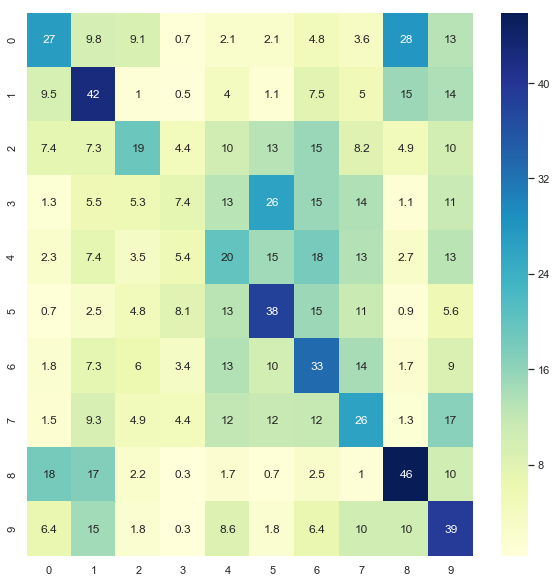

In [17]:
plt.figure(figsize = (10,10))
sn.set(font_scale=1)
sn.heatmap(100*cm/1000, cmap="YlGnBu", annot = True)